In [2]:
from mixer.models.modeling import MlpMixer, CONFIGS
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mixer.utils.data_utils import get_loader
from CKA_Google import cka, gram_rbf, gram_linear

In [ ]:
mixer = MlpMixer(CONFIGS['Mixer-B_16'])
mixer.load_from(np.load("mixer/checkpoint/Mixer-B_16.npz"))

In [3]:
mixer = MlpMixer(CONFIGS['Mixer-L_16'])
mixer.load_from(np.load("mixer/checkpoint/Mixer-L_16.npz"))

In [4]:
class Args:
    pass

args = Args()
args.local_rank = -1
args.img_size = 224
args.train_batch_size = 16
args.eval_batch_size = 16

In [ ]:
train_loader, test_loader = get_loader(args)

In [6]:
#https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/3
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for i, layer in enumerate(mixer.layer):
    layer.register_forward_hook(get_activation(i))

# print(next(iter(train_loader)))
# output = mixer(next(iter(train_loader))[0])
output = mixer(next(iter(imagenet_loader))[0])

# activation

In [7]:
def cka_rbf(a, b, sigma=1):
    return cka(
        gram_rbf(a.numpy(), sigma),
        gram_rbf(b.numpy(), sigma)
    )


def cka_linear(a, b, sigma=1):
    return cka(
        gram_linear(a.numpy(), sigma),
        gram_linear(b.numpy(), sigma)
    )


def compute_heatmap(mixer, activations, cka_func=cka_rbf):
    num_layers = len(mixer.layer)

    mean_activations = []
    for i in range(num_layers):
        mean_activation = activations[i].mean(axis=0)
        mean_activations.append(mean_activation)
    
    heatmap = np.zeros((num_layers, num_layers))
    for i in range(num_layers):
        for j in range(num_layers):
            heatmap[i][j] = cka_func(mean_activations[i], mean_activations[j])
    return heatmap


def display_heatmap(heatmap):
    sns.set()
    ax = sns.heatmap(heatmap, vmin=0, vmax=1)
    ax.invert_yaxis()
    plt.show()

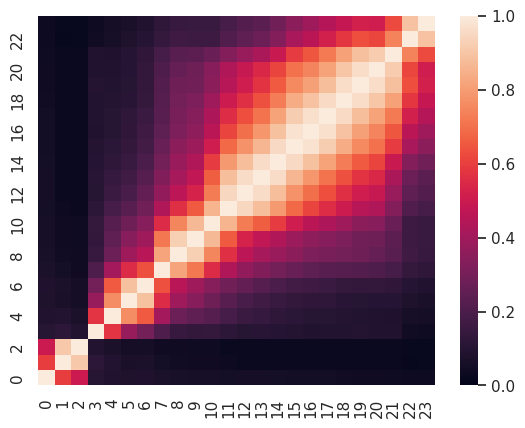

In [8]:
heatmap = compute_heatmap(mixer, activation)
display_heatmap(heatmap)

In [5]:
import torch

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler


def get_imagenet_loader(args):
    transform_test = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    testset = datasets.ImageFolder(
        root='/mnt/fastdata/datasets/ILSVRC2012-test-partial/', 
        transform=transform_test
    )
    test_sampler = RandomSampler(testset)
    test_loader = DataLoader(testset,
                             sampler=test_sampler,
                             batch_size=args.eval_batch_size,
                             num_workers=4,
                             pin_memory=True) if testset is not None else None

    return test_loader

imagenet_loader = get_imagenet_loader(args)